In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
def warpImages(img1, img2, H):
  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2) #coordinates of a reference image
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2) #coordinates of second image

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)#calculate the transformation matrix

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

In [3]:
im=glob.glob("lance(3).jpg")
im1=cv2.imread(im[0])
im=glob.glob("lance(4).jpg")
im2=cv2.imread(im[0])
#convertit les images

In [4]:
orb=cv2.ORB_create(nfeatures=2000)
#configure un selecteur ORB pour 2000 points d'intérêts

In [6]:
k1,d1=orb.detectAndCompute(im1,None)
k2,d2=orb.detectAndCompute(im2,None)
#detect et calcul les points d'intérêts
#k: les keypoints contiennent les informations relatives aux points d'intérêts eux-mêmes
#d: les descriptors contiennent des informations sur l'environnemnet globale des keypoints

In [20]:
d1

array([[209,  88, 111, ..., 160, 113, 120],
       [209,  12, 223, ..., 240,  97,  40],
       [ 61, 125, 249, ..., 243,  98, 179],
       ...,
       [ 82, 162, 144, ...,   5,  11,   5],
       [224, 107, 121, ..., 184,  86, 107],
       [ 35, 223,  64, ..., 158, 185, 157]], dtype=uint8)

In [7]:
bf=cv2.BFMatcher_create(cv2.NORM_HAMMING)
#on prépare un selecteur qui vas comparer les paires de points d'intérêts et déterminer lesquels sont similaires

In [8]:
matches = bf.knnMatch(d1, d2,k=2)
#on applique le selecteur avec knn, et 2 options pour chaque points

In [9]:
good=[]
for m,n in matches:
    if m.distance < 0.6*n.distance:
        good.append(m)
#ici l'objectif est de ne garder que les points qui ont une 
# similarité significative par rapport aux autres options 
# (donc grande similarité sur le premier, petite sur les autres car on a identifié des points identiques)

In [10]:
MIN_MATCH_COUNT=5
if len(good)>MIN_MATCH_COUNT:#seuil arbitraire de points similaire pour faire de l'homography
    src_pts = np.float32([ k1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ k2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
#calcul simplifié de la matrice d'homography sur les points d'intérêts communs

In [18]:
M

array([[ 9.99730308e-01, -2.40036434e-06, -6.42844211e+02],
       [-2.83499550e-04,  9.99788778e-01,  4.02321569e+01],
       [-1.31649511e-07,  5.45825636e-08,  1.00000000e+00]])

In [11]:
result = warpImages(im2, im1, M)

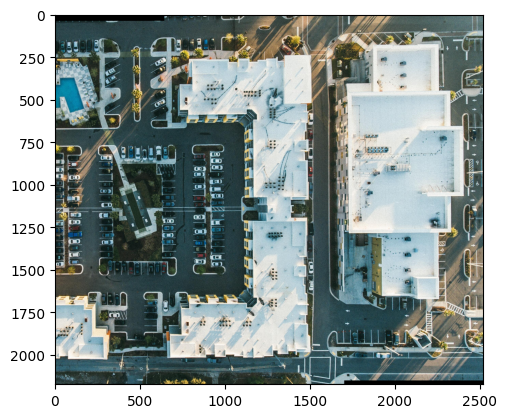

In [12]:
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB )  
plt.imshow(result)

plt.show()

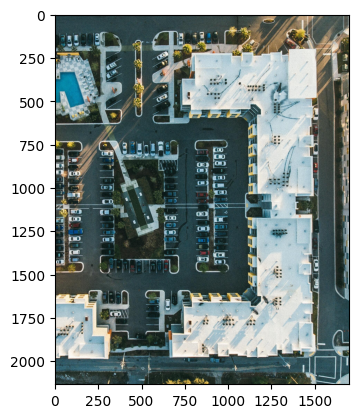

In [13]:
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB ))
plt.show()

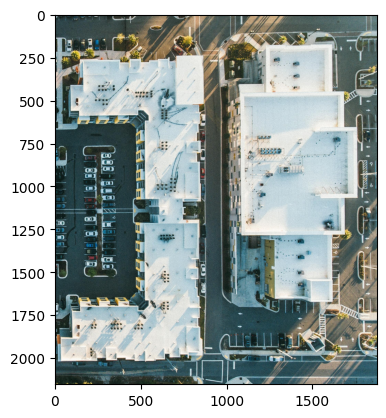

In [14]:
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB ))
plt.show()

In [55]:
result.shape

(2209, 2087, 3)

In [56]:
im1.shape

(2207, 1587, 3)

In [57]:
im2.shape

(2089, 1469, 3)